Device: cuda
Layer 0 attn shape: (256, 4, 16, 16), mean: 0.0625, std: 0.0756, min: 0.0002, max: 0.9628
Layer 1 attn shape: (256, 4, 16, 16), mean: 0.0625, std: 0.0704, min: 0.0001, max: 0.9445
Done training in 3.2s


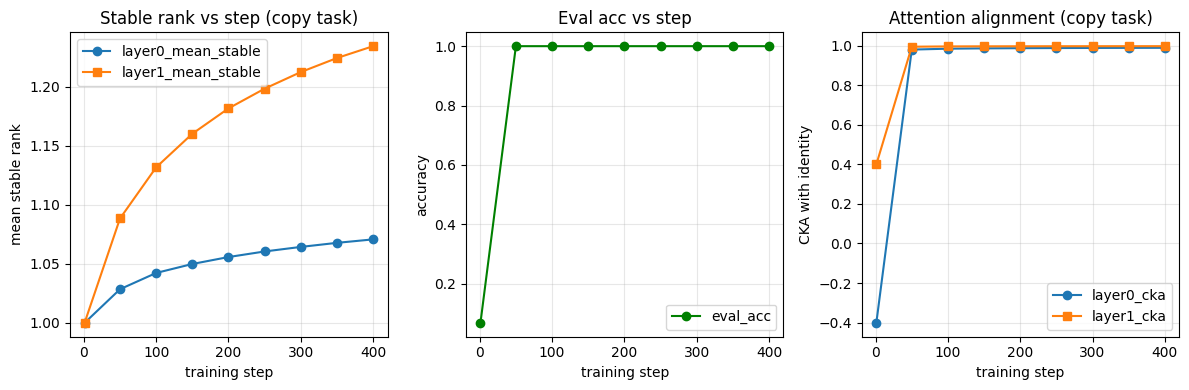


Final metrics:

Layer 0:
  head_stable_mean: 1.1374293863773346
  head_part_mean: 4.26888832449913
  head_entropy_mean: 6.9607168436050415
  head_top1_mean: 0.8912680596113205
  head_sv0_mean: 1.000226229429245
  mean_stable: 1.0707330703735352
  mean_participation: 3.8142142295837402
  mean_entropy_rank: 7.819092750549316
  mean_top1: 0.9339395761489868
  mean_sv0: 1.0000941753387451
  cka_align_identity: 0.9884547202052351

Layer 1:
  head_stable_mean: 1.2812682092189789
  head_part_mean: 6.573602259159088
  head_entropy_mean: 10.415458083152771
  head_top1_mean: 0.7988501936197281
  head_sv0_mean: 1.000228464603424
  mean_stable: 1.2341630458831787
  mean_participation: 6.668616771697998
  mean_entropy_rank: 11.120537757873535
  mean_top1: 0.8102657198905945
  mean_sv0: 1.0000524520874023
  cka_align_identity: 0.9967066468985892

Saved metrics_log_demo.json


In [14]:
# Tiny Transformer attention-rank probe (Colab-ready)
# Paste this cell into a new Colab notebook. Enable GPU for faster runs.

import os, time, math, random
from copy import deepcopy
from typing import Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# ------------------------------
# Synthetic Copy Task
# ------------------------------
class CopyDataset(Dataset):
    def __init__(self, seq_len=16, vocab_size=8, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y = x.clone()
        return x, y

# ------------------------------
# Custom Transformer with attention capture
# ------------------------------
class MultiHeadAttentionWithCapture(nn.Module):
    """Custom MHA that always returns attention weights"""
    def __init__(self, d_model, nhead, dropout=0.0):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        assert self.head_dim * nhead == d_model

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        B, T, C = query.shape

        # Project and reshape to (B, nhead, T, head_dim)
        Q = self.q_proj(query).view(B, T, self.nhead, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(B, T, self.nhead, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(B, T, self.nhead, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if attn_mask is not None:
            scores = scores + attn_mask

        attn_weights = F.softmax(scores, dim=-1)  # (B, nhead, T, T)
        attn_weights = self.dropout(attn_weights)

        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V)  # (B, nhead, T, head_dim)

        # Concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        output = self.out_proj(attn_output)

        return output, attn_weights

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttentionWithCapture(d_model, nhead, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        self.last_attn_weights = None

    def forward(self, x):
        # Self-attention with residual
        attn_out, attn_weights = self.attn(x, x, x)
        self.last_attn_weights = attn_weights.detach().cpu().numpy()
        x = self.norm1(x + attn_out)

        # FFN with residual
        x = self.norm2(x + self.ffn(x))
        return x

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size=16, d_model=64, nhead=4, num_layers=2,
                 dim_feedforward=128, seq_len=16, max_pos=512, use_pos=True, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.embed = nn.Embedding(vocab_size, d_model)
        self.use_pos = use_pos
        if use_pos:
            self.pos_embed = nn.Parameter(torch.randn(1, max_pos, d_model) * 0.02)
        else:
            self.pos_embed = None

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, T = x.shape
        emb = self.embed(x)
        if self.use_pos:
            pe = self.pos_embed[:, :T, :]
            emb = emb + pe

        out = emb
        for layer in self.layers:
            out = layer(out)

        out = self.norm(out)
        logits = self.head(out)
        return logits

    def get_cached_attentions(self):
        """Return list of attention weights from each layer"""
        return [layer.last_attn_weights for layer in self.layers]

# ------------------------------
# Rank and alignment metrics
# ------------------------------
def stable_rank_from_svals(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    fro_sq = np.sum(s**2)
    op_sq = (s[0]**2) if s.size>0 else 1e-12
    return float(max(1e-12, fro_sq / (op_sq + 1e-12)))

def participation_ratio(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    s_norm = s / (s.sum() + 1e-12)
    return float((s_norm.sum()**2) / (np.sum(s_norm**2) + 1e-12))

def entropy_effective_rank(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    p = s / (s.sum() + 1e-12)
    p = p[p>0]
    ent = -np.sum(p * np.log(p + 1e-12))
    return float(np.exp(ent))

def topk_energy_fraction(svals, k=1):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    energy = np.sum(s**2)
    topk = np.sum(s[:k]**2)
    return float(topk / (energy + 1e-12))

def linear_CKA(A, B):
    def center(K):
        Kc = K - K.mean(axis=0, keepdims=True) - K.mean(axis=1, keepdims=True) + K.mean()
        return Kc
    A_c = center(A)
    B_c = center(B)
    hsic = np.sum(A_c * B_c)
    denom = np.sqrt(np.sum(A_c * A_c) * np.sum(B_c * B_c) + 1e-12)
    return float(hsic / denom)

def compute_layer_attention_metrics(attn_tensor):
    if attn_tensor is None:
        return {}
    B, nhead, T, _ = attn_tensor.shape
    mean_per_head = attn_tensor.mean(axis=0)
    mean_across_heads = mean_per_head.mean(axis=0)
    metrics = {}

    head_stable = []
    head_part = []
    head_entropy_rank = []
    head_top1 = []
    head_sv0 = []

    for h in range(nhead):
        M = mean_per_head[h]
        try:
            svals = np.linalg.svd(M, compute_uv=False)
        except Exception:
            svals = np.linalg.svd(M + 1e-12 * np.eye(T), compute_uv=False)
        head_stable.append(stable_rank_from_svals(svals))
        head_part.append(participation_ratio(svals))
        head_entropy_rank.append(entropy_effective_rank(svals))
        head_top1.append(topk_energy_fraction(svals, k=1))
        head_sv0.append(float(svals[0] if svals.size>0 else 0.0))

    metrics['head_stable_mean'] = float(np.mean(head_stable))
    metrics['head_part_mean'] = float(np.mean(head_part))
    metrics['head_entropy_mean'] = float(np.mean(head_entropy_rank))
    metrics['head_top1_mean'] = float(np.mean(head_top1))
    metrics['head_sv0_mean'] = float(np.mean(head_sv0))

    M = mean_across_heads
    try:
        svals = np.linalg.svd(M, compute_uv=False)
    except Exception:
        svals = np.linalg.svd(M + 1e-12 * np.eye(T), compute_uv=False)
    metrics['mean_stable'] = stable_rank_from_svals(svals)
    metrics['mean_participation'] = participation_ratio(svals)
    metrics['mean_entropy_rank'] = entropy_effective_rank(svals)
    metrics['mean_top1'] = topk_energy_fraction(svals, k=1)
    metrics['mean_sv0'] = float(svals[0] if svals.size>0 else 0.0)
    return metrics

# ------------------------------
# Train / probe routine
# ------------------------------
def run_experiment_copy(seq_len=16, vocab_size=16, d_model=64, nhead=4, num_layers=2,
                        dim_feedforward=128, use_pos=True, batch_size=64, steps=800,
                        probe_size=512, checkpoint_every=100, device=None, seed=0):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    model = TinyTransformer(vocab_size=vocab_size, d_model=d_model, nhead=nhead,
                           num_layers=num_layers, dim_feedforward=dim_feedforward,
                           seq_len=seq_len, use_pos=use_pos)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_ds = CopyDataset(seq_len=seq_len, vocab_size=vocab_size, dataset_size=2048)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    probe_ds = CopyDataset(seq_len=seq_len, vocab_size=vocab_size, dataset_size=probe_size)
    probe_loader = DataLoader(probe_ds, batch_size=64, shuffle=False)

    metrics_log = []
    step = 0
    start_time = time.time()

    while step < steps:
        for xb, yb in train_loader:
            model.train()
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            B, T, V = logits.shape
            loss = criterion(logits.view(B*T, V), yb.view(B*T))
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            step += 1

            if step % checkpoint_every == 0 or step == 1:
                model.eval()
                with torch.no_grad():
                    layer_attn_list = [[] for _ in range(num_layers)]
                    for pb_x, pb_y in probe_loader:
                        pb_x = pb_x.to(device)
                        _ = model(pb_x)
                        atts = model.get_cached_attentions()
                        for li, a in enumerate(atts):
                            if a is not None:
                                layer_attn_list[li].append(a)

                    layer_attn_concat = []
                    for li in range(num_layers):
                        if len(layer_attn_list[li]) > 0:
                            layer_attn_concat.append(np.concatenate(layer_attn_list[li], axis=0))
                        else:
                            layer_attn_concat.append(None)

                    per_layer_metrics = {}
                    for li, attn_tensor in enumerate(layer_attn_concat):
                        if attn_tensor is not None:
                            m = compute_layer_attention_metrics(attn_tensor)
                            actual_T = attn_tensor.shape[2]
                            S = np.eye(actual_T)
                            mean_attn = attn_tensor.mean(axis=0).mean(axis=0)
                            align = linear_CKA(mean_attn, S)
                            m['cka_align_identity'] = align
                        else:
                            m = {'error': 'no attention captured'}
                        per_layer_metrics[f'layer{li}'] = m

                    xb_eval, yb_eval = next(iter(probe_loader))
                    xb_eval = xb_eval.to(device); yb_eval = yb_eval.to(device)
                    logits_eval = model(xb_eval)
                    B_e = logits_eval.shape[0]
                    loss_eval = criterion(logits_eval.view(B_e*T, V), yb_eval.view(B_e*T)).item()
                    pred = logits_eval.argmax(dim=-1)
                    acc = (pred == yb_eval).float().mean().item()

                    # Debug: print attention stats at first checkpoint
                    if step == checkpoint_every:
                        for li, attn in enumerate(layer_attn_concat):
                            if attn is not None:
                                print(f"Layer {li} attn shape: {attn.shape}, mean: {attn.mean():.4f}, std: {attn.std():.4f}, min: {attn.min():.4f}, max: {attn.max():.4f}")
                            else:
                                print(f"Layer {li} attn: None")

                    metrics_log.append({
                        'step': step, 'time': time.time()-start_time, 'train_loss': float(loss.item()),
                        'eval_loss': float(loss_eval), 'eval_acc': float(acc), 'per_layer': per_layer_metrics
                    })
                model.train()
            if step >= steps:
                break

    print("Done training in {:.1f}s".format(time.time()-start_time))
    return model, metrics_log

# ------------------------------
# Demo run & plots
# ------------------------------
def demo_and_plot():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model, metrics_log = run_experiment_copy(seq_len=16, vocab_size=16, d_model=64, nhead=4,
                                            num_layers=2, dim_feedforward=128, use_pos=True,
                                            batch_size=64, steps=400, probe_size=256,
                                            checkpoint_every=50, device=device, seed=42)

    steps = [m['step'] for m in metrics_log]
    eval_acc = [m['eval_acc'] for m in metrics_log]

    # Handle cases where metrics might have errors
    layer0_stable = []
    layer1_stable = []
    for m in metrics_log:
        l0 = m['per_layer'].get('layer0', {})
        l1 = m['per_layer'].get('layer1', {})
        layer0_stable.append(l0.get('mean_stable', 0))
        layer1_stable.append(l1.get('mean_stable', 0))

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.plot(steps, layer0_stable, label='layer0_mean_stable', marker='o')
    plt.plot(steps, layer1_stable, label='layer1_mean_stable', marker='s')
    plt.xlabel('training step'); plt.ylabel('mean stable rank')
    plt.title('Stable rank vs step (copy task)')
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1,3,2)
    plt.plot(steps, eval_acc, label='eval_acc', marker='o', color='green')
    plt.xlabel('training step'); plt.ylabel('accuracy')
    plt.title('Eval acc vs step')
    plt.grid(True, alpha=0.3); plt.legend()

    # Additional metric: CKA alignment
    layer0_cka = [m['per_layer'].get('layer0', {}).get('cka_align_identity', 0) for m in metrics_log]
    layer1_cka = [m['per_layer'].get('layer1', {}).get('cka_align_identity', 0) for m in metrics_log]

    plt.subplot(1,3,3)
    plt.plot(steps, layer0_cka, label='layer0_cka', marker='o')
    plt.plot(steps, layer1_cka, label='layer1_cka', marker='s')
    plt.xlabel('training step'); plt.ylabel('CKA with identity')
    plt.title('Attention alignment (copy task)')
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final per-layer metrics
    print("\nFinal metrics:")
    final = metrics_log[-1]['per_layer']
    for li in range(len(final)):
        print(f"\nLayer {li}:")
        for k, v in final[f'layer{li}'].items():
            print(f"  {k}: {v}")

    # Save metrics to json
    import json
    with open('metrics_log_demo.json', 'w') as f:
        json.dump(metrics_log, f, indent=2)
    print("\nSaved metrics_log_demo.json")

# Run demo
if __name__ == "__main__":
    demo_and_plot()

Device: cuda, Task: reverse
Step 100: acc=0.1559, loss=2.5061
  Layer 0: shape=(512, 8, 32, 32), mean=0.0312, std=0.0200
  Layer 1: shape=(512, 8, 32, 32), mean=0.0312, std=0.0136
  Layer 2: shape=(512, 8, 32, 32), mean=0.0312, std=0.0154
  Layer 3: shape=(512, 8, 32, 32), mean=0.0312, std=0.0202
Done training in 35.1s


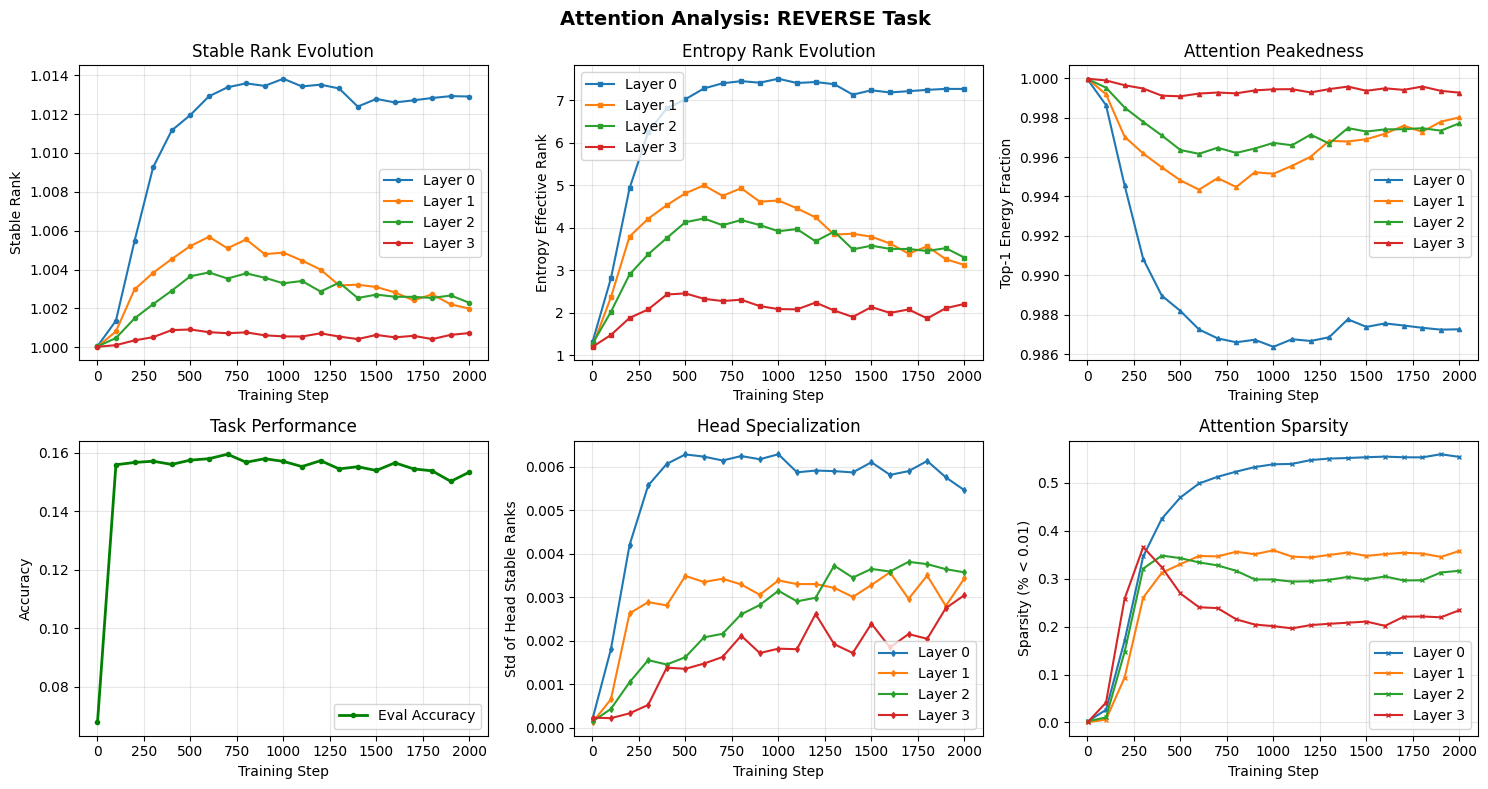


FINAL METRICS

Layer 0:
  head_stable_mean         : 1.0171
  head_stable_std          : 0.0055
  head_entropy_mean        : 7.4961
  head_top1_mean           : 0.9832
  mean_stable              : 1.0129
  mean_entropy_rank        : 7.2618
  mean_top1                : 0.9873
  mean_top3                : 0.9885
  sparsity                 : 0.5543

Layer 1:
  head_stable_mean         : 1.0061
  head_stable_std          : 0.0034
  head_entropy_mean        : 4.3710
  head_top1_mean           : 0.9939
  mean_stable              : 1.0020
  mean_entropy_rank        : 3.1221
  mean_top1                : 0.9980
  mean_top3                : 0.9983
  sparsity                 : 0.3581

Layer 2:
  head_stable_mean         : 1.0059
  head_stable_std          : 0.0036
  head_entropy_mean        : 4.2642
  head_top1_mean           : 0.9942
  mean_stable              : 1.0023
  mean_entropy_rank        : 3.2956
  mean_top1                : 0.9977
  mean_top3                : 0.9981
  sparsity         

In [10]:
# Enhanced Transformer attention-rank probe with harder tasks
# Larger model, longer training, more interesting dynamics

import os, time, math, random
from copy import deepcopy
from typing import Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# ------------------------------
# Multiple Task Types
# ------------------------------
class CopyDataset(Dataset):
    """Simple copy - too easy"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y = x.clone()
        return x, y

class ReverseDataset(Dataset):
    """Reverse sequence - requires non-local attention"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y = torch.flip(x, dims=[0])
        return x, y

class SortDataset(Dataset):
    """Sort sequence - harder, requires global reasoning"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y, _ = torch.sort(x)
        return x, y

class DuplicateDataset(Dataset):
    """Duplicate detection - attend to all positions"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = []
        for _ in range(dataset_size):
            seq = torch.randint(low=1, high=vocab_size, size=(seq_len,), dtype=torch.long)
            # Label: 1 if has duplicate, 0 otherwise
            unique_count = len(torch.unique(seq))
            label = 1 if unique_count < seq_len else 0
            self.data.append((seq, label))
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        return self.data[idx]

# ------------------------------
# Enhanced Transformer
# ------------------------------
class MultiHeadAttentionWithCapture(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        assert self.head_dim * nhead == d_model

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        B, T, C = query.shape

        Q = self.q_proj(query).view(B, T, self.nhead, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(B, T, self.nhead, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(B, T, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if attn_mask is not None:
            scores = scores + attn_mask

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        output = self.out_proj(attn_output)

        return output, attn_weights

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttentionWithCapture(d_model, nhead, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        self.last_attn_weights = None

    def forward(self, x):
        attn_out, attn_weights = self.attn(x, x, x)
        self.last_attn_weights = attn_weights.detach().cpu().numpy()
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x

class EnhancedTransformer(nn.Module):
    def __init__(self, vocab_size=16, d_model=128, nhead=8, num_layers=4,
                 dim_feedforward=512, seq_len=32, max_pos=512, use_pos=True,
                 dropout=0.1, task_type='seq2seq'):
        super().__init__()
        self.seq_len = seq_len
        self.task_type = task_type
        self.embed = nn.Embedding(vocab_size, d_model)
        self.use_pos = use_pos
        if use_pos:
            self.pos_embed = nn.Parameter(torch.randn(1, max_pos, d_model) * 0.02)
        else:
            self.pos_embed = None

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

        # Different heads for different tasks
        if task_type == 'seq2seq':
            self.head = nn.Linear(d_model, vocab_size)
        elif task_type == 'classification':
            self.head = nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model, 2)  # Binary classification
            )

    def forward(self, x):
        B, T = x.shape
        emb = self.embed(x)
        if self.use_pos:
            pe = self.pos_embed[:, :T, :]
            emb = emb + pe

        out = emb
        for layer in self.layers:
            out = layer(out)

        out = self.norm(out)

        if self.task_type == 'seq2seq':
            logits = self.head(out)
        elif self.task_type == 'classification':
            # Pool: mean across sequence
            pooled = out.mean(dim=1)
            logits = self.head(pooled)

        return logits

    def get_cached_attentions(self):
        return [layer.last_attn_weights for layer in self.layers]

# ------------------------------
# Metrics
# ------------------------------
def stable_rank_from_svals(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    fro_sq = np.sum(s**2)
    op_sq = (s[0]**2) if s.size>0 else 1e-12
    return float(max(1e-12, fro_sq / (op_sq + 1e-12)))

def entropy_effective_rank(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    p = s / (s.sum() + 1e-12)
    p = p[p>0]
    ent = -np.sum(p * np.log(p + 1e-12))
    return float(np.exp(ent))

def topk_energy_fraction(svals, k=1):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    energy = np.sum(s**2)
    topk = np.sum(s[:k]**2)
    return float(topk / (energy + 1e-12))

def compute_layer_attention_metrics(attn_tensor):
    if attn_tensor is None:
        return {}
    B, nhead, T, _ = attn_tensor.shape
    mean_per_head = attn_tensor.mean(axis=0)
    mean_across_heads = mean_per_head.mean(axis=0)
    metrics = {}

    # Per-head metrics
    head_stable = []
    head_entropy_rank = []
    head_top1 = []

    for h in range(nhead):
        M = mean_per_head[h]
        try:
            svals = np.linalg.svd(M, compute_uv=False)
        except Exception:
            svals = np.linalg.svd(M + 1e-12 * np.eye(T), compute_uv=False)
        head_stable.append(stable_rank_from_svals(svals))
        head_entropy_rank.append(entropy_effective_rank(svals))
        head_top1.append(topk_energy_fraction(svals, k=1))

    metrics['head_stable_mean'] = float(np.mean(head_stable))
    metrics['head_stable_std'] = float(np.std(head_stable))
    metrics['head_entropy_mean'] = float(np.mean(head_entropy_rank))
    metrics['head_top1_mean'] = float(np.mean(head_top1))

    # Aggregated attention metrics
    M = mean_across_heads
    try:
        svals = np.linalg.svd(M, compute_uv=False)
    except Exception:
        svals = np.linalg.svd(M + 1e-12 * np.eye(T), compute_uv=False)
    metrics['mean_stable'] = stable_rank_from_svals(svals)
    metrics['mean_entropy_rank'] = entropy_effective_rank(svals)
    metrics['mean_top1'] = topk_energy_fraction(svals, k=1)
    metrics['mean_top3'] = topk_energy_fraction(svals, k=3)

    # Attention sparsity (what fraction of attention is near zero)
    attn_flat = attn_tensor.flatten()
    metrics['sparsity'] = float(np.mean(attn_flat < 0.01))

    return metrics

# ------------------------------
# Training
# ------------------------------
def run_experiment(task='reverse', seq_len=32, vocab_size=16, d_model=128, nhead=8,
                   num_layers=4, dim_feedforward=512, use_pos=True, batch_size=64,
                   steps=2000, probe_size=512, checkpoint_every=100, device=None, seed=0):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}, Task: {task}")
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    # Select dataset
    if task == 'copy':
        train_ds = CopyDataset(seq_len, vocab_size, 4096)
        probe_ds = CopyDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
    elif task == 'reverse':
        train_ds = ReverseDataset(seq_len, vocab_size, 4096)
        probe_ds = ReverseDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
    elif task == 'sort':
        train_ds = SortDataset(seq_len, vocab_size, 4096)
        probe_ds = SortDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
    elif task == 'duplicate':
        train_ds = DuplicateDataset(seq_len, vocab_size, 4096)
        probe_ds = DuplicateDataset(seq_len, vocab_size, probe_size)
        task_type = 'classification'

    model = EnhancedTransformer(vocab_size=vocab_size, d_model=d_model, nhead=nhead,
                                num_layers=num_layers, dim_feedforward=dim_feedforward,
                                seq_len=seq_len, use_pos=use_pos, task_type=task_type)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

    if task_type == 'seq2seq':
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    probe_loader = DataLoader(probe_ds, batch_size=64, shuffle=False)

    metrics_log = []
    step = 0
    start_time = time.time()

    while step < steps:
        for xb, yb in train_loader:
            model.train()
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)

            if task_type == 'seq2seq':
                B, T, V = logits.shape
                loss = criterion(logits.view(B*T, V), yb.view(B*T))
            else:
                loss = criterion(logits, yb)

            optimizer.zero_grad(); loss.backward(); optimizer.step()
            step += 1

            if step % checkpoint_every == 0 or step == 1:
                model.eval()
                with torch.no_grad():
                    # Collect attention
                    layer_attn_list = [[] for _ in range(num_layers)]
                    for pb_x, pb_y in probe_loader:
                        pb_x = pb_x.to(device)
                        _ = model(pb_x)
                        atts = model.get_cached_attentions()
                        for li, a in enumerate(atts):
                            if a is not None:
                                layer_attn_list[li].append(a)

                    layer_attn_concat = []
                    for li in range(num_layers):
                        if len(layer_attn_list[li]) > 0:
                            layer_attn_concat.append(np.concatenate(layer_attn_list[li], axis=0))
                        else:
                            layer_attn_concat.append(None)

                    per_layer_metrics = {}
                    for li, attn_tensor in enumerate(layer_attn_concat):
                        if attn_tensor is not None:
                            m = compute_layer_attention_metrics(attn_tensor)
                        else:
                            m = {'error': 'no attention captured'}
                        per_layer_metrics[f'layer{li}'] = m

                    # Evaluate
                    total_correct = 0
                    total_samples = 0
                    eval_loss = 0
                    for xb_eval, yb_eval in probe_loader:
                        xb_eval = xb_eval.to(device); yb_eval = yb_eval.to(device)
                        logits_eval = model(xb_eval)

                        if task_type == 'seq2seq':
                            B_e, T_e, V = logits_eval.shape
                            eval_loss += criterion(logits_eval.view(B_e*T_e, V), yb_eval.view(B_e*T_e)).item()
                            pred = logits_eval.argmax(dim=-1)
                            total_correct += (pred == yb_eval).float().sum().item()
                            total_samples += B_e * T_e
                        else:
                            eval_loss += criterion(logits_eval, yb_eval).item()
                            pred = logits_eval.argmax(dim=-1)
                            total_correct += (pred == yb_eval).float().sum().item()
                            total_samples += yb_eval.shape[0]

                    acc = total_correct / total_samples
                    eval_loss = eval_loss / len(probe_loader)

                    if step == checkpoint_every:
                        print(f"Step {step}: acc={acc:.4f}, loss={eval_loss:.4f}")
                        for li, attn in enumerate(layer_attn_concat):
                            if attn is not None:
                                print(f"  Layer {li}: shape={attn.shape}, mean={attn.mean():.4f}, std={attn.std():.4f}")

                    metrics_log.append({
                        'step': step, 'time': time.time()-start_time,
                        'train_loss': float(loss.item()),
                        'eval_loss': float(eval_loss),
                        'eval_acc': float(acc),
                        'per_layer': per_layer_metrics
                    })
                model.train()
            if step >= steps:
                break

    print(f"Done training in {time.time()-start_time:.1f}s")
    return model, metrics_log

# ------------------------------
# Visualization
# ------------------------------
def plot_results(metrics_log, num_layers, task_name):
    steps = [m['step'] for m in metrics_log]
    eval_acc = [m['eval_acc'] for m in metrics_log]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Attention Analysis: {task_name.upper()} Task', fontsize=14, fontweight='bold')

    # Stable rank
    ax = axes[0, 0]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_stable', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='o', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Stable Rank')
    ax.set_title('Stable Rank Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Entropy effective rank
    ax = axes[0, 1]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_entropy_rank', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='s', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Entropy Effective Rank')
    ax.set_title('Entropy Rank Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Top-1 energy
    ax = axes[0, 2]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_top1', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='^', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Top-1 Energy Fraction')
    ax.set_title('Attention Peakedness')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Accuracy
    ax = axes[1, 0]
    ax.plot(steps, eval_acc, label='Eval Accuracy', marker='o', markersize=3, color='green', linewidth=2)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Accuracy')
    ax.set_title('Task Performance')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Per-head stable rank variation
    ax = axes[1, 1]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('head_stable_std', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='d', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Std of Head Stable Ranks')
    ax.set_title('Head Specialization')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Sparsity
    ax = axes[1, 2]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('sparsity', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='x', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Sparsity (% < 0.01)')
    ax.set_title('Attention Sparsity')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ------------------------------
# Demo
# ------------------------------
def demo_and_plot():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Choose task: 'copy', 'reverse', 'sort', or 'duplicate'
    task = 'reverse'  # Change this to experiment with different tasks

    model, metrics_log = run_experiment(
        task=task,
        seq_len=32,
        vocab_size=16,
        d_model=128,
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        use_pos=True,
        batch_size=64,
        steps=2000,
        probe_size=512,
        checkpoint_every=100,
        device=device,
        seed=42
    )

    plot_results(metrics_log, num_layers=4, task_name=task)

    # Print final metrics
    print("\n" + "="*60)
    print("FINAL METRICS")
    print("="*60)
    final = metrics_log[-1]['per_layer']
    for li in range(4):
        print(f"\nLayer {li}:")
        layer_metrics = final.get(f'layer{li}', {})
        for k, v in layer_metrics.items():
            if isinstance(v, float):
                print(f"  {k:25s}: {v:.4f}")

    # Save
    import json
    with open(f'metrics_{task}.json', 'w') as f:
        json.dump(metrics_log, f, indent=2)
    print(f"\nSaved metrics_{task}.json")

if __name__ == "__main__":
    demo_and_plot()


ATTENTION RANK EVOLUTION EXPERIMENT

Task: TEXT

Hypothesis on rank evolution:
- Text prediction: Rank may DECREASE as model learns
  local patterns (attend to recent tokens)
- Early layers: Higher rank (broad context)
- Later layers: Lower rank (focused on prediction)

Device: cuda, Task: text


Training text:   0%|          | 0/2000 [00:00<?, ?step/s]


Step 100: acc=0.2029, eval_loss=2.8567
  Layer 0: shape=(512, 8, 63, 63), mean=0.0159, std=0.0075
  Layer 1: shape=(512, 8, 63, 63), mean=0.0159, std=0.0098
  Layer 2: shape=(512, 8, 63, 63), mean=0.0159, std=0.0125
  Layer 3: shape=(512, 8, 63, 63), mean=0.0159, std=0.0101
Done training in 64.0s


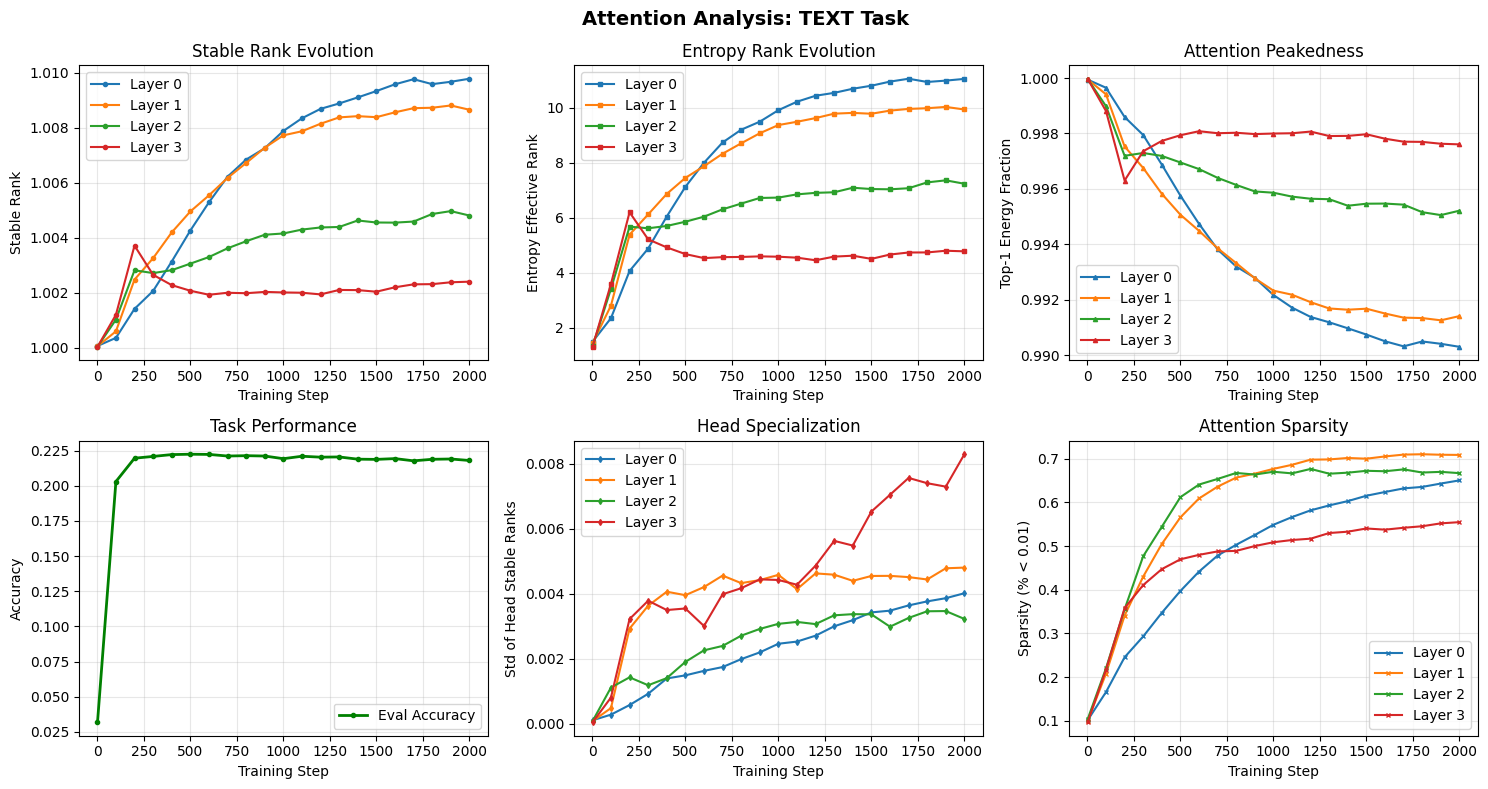


FINAL METRICS

Layer 0:
  head_stable_mean         : 1.0185
  head_stable_std          : 0.0040
  head_entropy_mean        : 13.3217
  head_top1_mean           : 0.9819
  mean_stable              : 1.0098
  mean_entropy_rank        : 11.0518
  mean_top1                : 0.9903
  mean_top3                : 0.9910
  sparsity                 : 0.6507

Layer 1:
  head_stable_mean         : 1.0168
  head_stable_std          : 0.0048
  head_entropy_mean        : 12.5016
  head_top1_mean           : 0.9835
  mean_stable              : 1.0087
  mean_entropy_rank        : 9.9393
  mean_top1                : 0.9914
  mean_top3                : 0.9920
  sparsity                 : 0.7090

Layer 2:
  head_stable_mean         : 1.0109
  head_stable_std          : 0.0032
  head_entropy_mean        : 9.7802
  head_top1_mean           : 0.9892
  mean_stable              : 1.0048
  mean_entropy_rank        : 7.2407
  mean_top1                : 0.9952
  mean_top3                : 0.9956
  sparsity      

In [11]:
# Enhanced Transformer attention-rank probe with harder tasks
# Larger model, longer training, more interesting dynamics

import os, time, math, random
from copy import deepcopy
from typing import Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ------------------------------
# Multiple Task Types
# ------------------------------
class CopyDataset(Dataset):
    """Simple copy - too easy"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y = x.clone()
        return x, y

class ReverseDataset(Dataset):
    """Reverse sequence - requires non-local attention"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y = torch.flip(x, dims=[0])
        return x, y

class SortDataset(Dataset):
    """Sort sequence - harder, requires global reasoning"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y, _ = torch.sort(x)
        return x, y

class DuplicateDataset(Dataset):
    """Duplicate detection - attend to all positions"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = []
        for _ in range(dataset_size):
            seq = torch.randint(low=1, high=vocab_size, size=(seq_len,), dtype=torch.long)
            # Label: 1 if has duplicate, 0 otherwise
            unique_count = len(torch.unique(seq))
            label = 1 if unique_count < seq_len else 0
            self.data.append((seq, label))
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        return self.data[idx]

class TextPredictionDataset(Dataset):
    """Causal language modeling on character-level text"""
    def __init__(self, seq_len=64, dataset_size=4096, text_source='shakespeare'):
        self.seq_len = seq_len
        self.dataset_size = dataset_size

        # Generate synthetic "text-like" data with patterns
        if text_source == 'synthetic':
            # Create patterns: repeated subsequences, gradual changes
            vocab_size = 27  # a-z + space
            self.data = []
            for _ in range(dataset_size):
                seq = []
                # Add structured patterns
                for i in range(seq_len):
                    if i % 10 < 3:  # Repeating pattern every 10
                        val = (i % 10) + 1
                    elif i % 10 < 6:
                        val = ((i + dataset_size) % 15) + 1
                    else:
                        val = random.randint(1, vocab_size-1)
                    seq.append(val)
                self.data.append(torch.tensor(seq, dtype=torch.long))
            self.vocab_size = vocab_size
        else:
            # Simple text patterns
            vocab_size = 32
            self.vocab_size = vocab_size
            self.data = []
            for _ in range(dataset_size):
                # Create sequences with local dependencies
                seq = [random.randint(1, vocab_size-1)]
                for i in range(1, seq_len):
                    # 50% chance to depend on previous token, 50% random
                    if random.random() < 0.5:
                        seq.append((seq[-1] + random.randint(1, 5)) % vocab_size)
                    else:
                        seq.append(random.randint(1, vocab_size-1))
                self.data.append(torch.tensor(seq, dtype=torch.long))

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        seq = self.data[idx]
        # Input: seq[:-1], Target: seq[1:] (next token prediction)
        return seq[:-1].clone(), seq[1:].clone()

class ImageClassificationDataset(Dataset):
    """Flattened image patches for classification (MNIST-like)"""
    def __init__(self, img_size=8, num_classes=10, dataset_size=4096):
        self.img_size = img_size
        self.num_classes = num_classes
        self.dataset_size = dataset_size
        self.seq_len = img_size * img_size  # Flatten image to sequence
        self.vocab_size = 256  # Pixel values

        self.data = []
        for _ in range(dataset_size):
            # Generate synthetic images with class-specific patterns
            label = random.randint(0, num_classes - 1)

            # Create image with pattern based on class
            img = torch.zeros(img_size, img_size, dtype=torch.long)

            # Add class-specific patterns
            if label < 5:  # Vertical patterns
                col = label
                img[:, col] = 200
            else:  # Horizontal patterns
                row = label - 5
                img[row, :] = 200

            # Add noise
            noise = torch.randint(0, 50, (img_size, img_size), dtype=torch.long)
            img = torch.clamp(img + noise, 0, 255)

            # Flatten to sequence
            seq = img.flatten()
            self.data.append((seq, label))

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.data[idx]

# ------------------------------
# Enhanced Transformer
# ------------------------------
class MultiHeadAttentionWithCapture(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        assert self.head_dim * nhead == d_model

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        B, T, C = query.shape

        Q = self.q_proj(query).view(B, T, self.nhead, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(B, T, self.nhead, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(B, T, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if attn_mask is not None:
            scores = scores + attn_mask

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        output = self.out_proj(attn_output)

        return output, attn_weights

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttentionWithCapture(d_model, nhead, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        self.last_attn_weights = None

    def forward(self, x):
        attn_out, attn_weights = self.attn(x, x, x)
        self.last_attn_weights = attn_weights.detach().cpu().numpy()
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x

class EnhancedTransformer(nn.Module):
    def __init__(self, vocab_size=16, d_model=128, nhead=8, num_layers=4,
                 dim_feedforward=512, seq_len=32, max_pos=512, use_pos=True,
                 dropout=0.1, task_type='seq2seq', num_classes=10):
        super().__init__()
        self.seq_len = seq_len
        self.task_type = task_type
        self.embed = nn.Embedding(vocab_size, d_model)
        self.use_pos = use_pos
        if use_pos:
            self.pos_embed = nn.Parameter(torch.randn(1, max_pos, d_model) * 0.02)
        else:
            self.pos_embed = None

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

        # Different heads for different tasks
        if task_type == 'seq2seq' or task_type == 'causal_lm':
            self.head = nn.Linear(d_model, vocab_size)
        elif task_type == 'classification':
            self.head = nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model, num_classes)
            )

    def forward(self, x):
        B, T = x.shape
        emb = self.embed(x)
        if self.use_pos:
            pe = self.pos_embed[:, :T, :]
            emb = emb + pe

        out = emb
        for layer in self.layers:
            out = layer(out)

        out = self.norm(out)

        if self.task_type in ['seq2seq', 'causal_lm']:
            logits = self.head(out)
        elif self.task_type == 'classification':
            # Pool: mean across sequence
            pooled = out.mean(dim=1)
            logits = self.head(pooled)

        return logits

    def get_cached_attentions(self):
        return [layer.last_attn_weights for layer in self.layers]

# ------------------------------
# Metrics
# ------------------------------
def stable_rank_from_svals(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    fro_sq = np.sum(s**2)
    op_sq = (s[0]**2) if s.size>0 else 1e-12
    return float(max(1e-12, fro_sq / (op_sq + 1e-12)))

def entropy_effective_rank(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    p = s / (s.sum() + 1e-12)
    p = p[p>0]
    ent = -np.sum(p * np.log(p + 1e-12))
    return float(np.exp(ent))

def topk_energy_fraction(svals, k=1):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    energy = np.sum(s**2)
    topk = np.sum(s[:k]**2)
    return float(topk / (energy + 1e-12))

def compute_layer_attention_metrics(attn_tensor):
    if attn_tensor is None:
        return {}
    B, nhead, T, _ = attn_tensor.shape
    mean_per_head = attn_tensor.mean(axis=0)
    mean_across_heads = mean_per_head.mean(axis=0)
    metrics = {}

    # Per-head metrics
    head_stable = []
    head_entropy_rank = []
    head_top1 = []

    for h in range(nhead):
        M = mean_per_head[h]
        try:
            svals = np.linalg.svd(M, compute_uv=False)
        except Exception:
            svals = np.linalg.svd(M + 1e-12 * np.eye(T), compute_uv=False)
        head_stable.append(stable_rank_from_svals(svals))
        head_entropy_rank.append(entropy_effective_rank(svals))
        head_top1.append(topk_energy_fraction(svals, k=1))

    metrics['head_stable_mean'] = float(np.mean(head_stable))
    metrics['head_stable_std'] = float(np.std(head_stable))
    metrics['head_entropy_mean'] = float(np.mean(head_entropy_rank))
    metrics['head_top1_mean'] = float(np.mean(head_top1))

    # Aggregated attention metrics
    M = mean_across_heads
    try:
        svals = np.linalg.svd(M, compute_uv=False)
    except Exception:
        svals = np.linalg.svd(M + 1e-12 * np.eye(T), compute_uv=False)
    metrics['mean_stable'] = stable_rank_from_svals(svals)
    metrics['mean_entropy_rank'] = entropy_effective_rank(svals)
    metrics['mean_top1'] = topk_energy_fraction(svals, k=1)
    metrics['mean_top3'] = topk_energy_fraction(svals, k=3)

    # Attention sparsity (what fraction of attention is near zero)
    attn_flat = attn_tensor.flatten()
    metrics['sparsity'] = float(np.mean(attn_flat < 0.01))

    return metrics

# ------------------------------
# Training
# ------------------------------
def run_experiment(task='reverse', seq_len=32, vocab_size=16, d_model=128, nhead=8,
                   num_layers=4, dim_feedforward=512, use_pos=True, batch_size=64,
                   steps=2000, probe_size=512, checkpoint_every=100, device=None, seed=0):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}, Task: {task}")
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    # Select dataset
    if task == 'copy':
        train_ds = CopyDataset(seq_len, vocab_size, 4096)
        probe_ds = CopyDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
        num_classes = 2
    elif task == 'reverse':
        train_ds = ReverseDataset(seq_len, vocab_size, 4096)
        probe_ds = ReverseDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
        num_classes = 2
    elif task == 'sort':
        train_ds = SortDataset(seq_len, vocab_size, 4096)
        probe_ds = SortDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
        num_classes = 2
    elif task == 'duplicate':
        train_ds = DuplicateDataset(seq_len, vocab_size, 4096)
        probe_ds = DuplicateDataset(seq_len, vocab_size, probe_size)
        task_type = 'classification'
        num_classes = 2
    elif task == 'text':
        train_ds = TextPredictionDataset(seq_len, 4096)
        probe_ds = TextPredictionDataset(seq_len, probe_size)
        vocab_size = train_ds.vocab_size
        task_type = 'causal_lm'
        num_classes = vocab_size
    elif task == 'image':
        img_size = 8  # 8x8 images
        train_ds = ImageClassificationDataset(img_size, 10, 4096)
        probe_ds = ImageClassificationDataset(img_size, 10, probe_size)
        seq_len = img_size * img_size
        vocab_size = 256
        task_type = 'classification'
        num_classes = 10

    model = EnhancedTransformer(vocab_size=vocab_size, d_model=d_model, nhead=nhead,
                                num_layers=num_layers, dim_feedforward=dim_feedforward,
                                seq_len=seq_len, use_pos=use_pos, task_type=task_type,
                                num_classes=num_classes)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    probe_loader = DataLoader(probe_ds, batch_size=64, shuffle=False)

    metrics_log = []
    step = 0
    start_time = time.time()

    # Progress bar
    pbar = tqdm(total=steps, desc=f"Training {task}", unit="step")

    while step < steps:
        for xb, yb in train_loader:
            model.train()
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)

            if task_type in ['seq2seq', 'causal_lm']:
                B, T, V = logits.shape
                loss = criterion(logits.view(B*T, V), yb.view(B*T))
            else:
                loss = criterion(logits, yb)

            optimizer.zero_grad(); loss.backward(); optimizer.step()
            step += 1
            pbar.update(1)
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            if step % checkpoint_every == 0 or step == 1:
                model.eval()
                with torch.no_grad():
                    # Collect attention
                    layer_attn_list = [[] for _ in range(num_layers)]
                    for pb_x, pb_y in probe_loader:
                        pb_x = pb_x.to(device)
                        _ = model(pb_x)
                        atts = model.get_cached_attentions()
                        for li, a in enumerate(atts):
                            if a is not None:
                                layer_attn_list[li].append(a)

                    layer_attn_concat = []
                    for li in range(num_layers):
                        if len(layer_attn_list[li]) > 0:
                            layer_attn_concat.append(np.concatenate(layer_attn_list[li], axis=0))
                        else:
                            layer_attn_concat.append(None)

                    per_layer_metrics = {}
                    for li, attn_tensor in enumerate(layer_attn_concat):
                        if attn_tensor is not None:
                            m = compute_layer_attention_metrics(attn_tensor)
                        else:
                            m = {'error': 'no attention captured'}
                        per_layer_metrics[f'layer{li}'] = m

                    # Evaluate
                    total_correct = 0
                    total_samples = 0
                    eval_loss = 0
                    for xb_eval, yb_eval in probe_loader:
                        xb_eval = xb_eval.to(device); yb_eval = yb_eval.to(device)
                        logits_eval = model(xb_eval)

                        if task_type in ['seq2seq', 'causal_lm']:
                            B_e, T_e, V = logits_eval.shape
                            eval_loss += criterion(logits_eval.view(B_e*T_e, V), yb_eval.view(B_e*T_e)).item()
                            pred = logits_eval.argmax(dim=-1)
                            total_correct += (pred == yb_eval).float().sum().item()
                            total_samples += B_e * T_e
                        else:
                            eval_loss += criterion(logits_eval, yb_eval).item()
                            pred = logits_eval.argmax(dim=-1)
                            total_correct += (pred == yb_eval).float().sum().item()
                            total_samples += yb_eval.shape[0]

                    acc = total_correct / total_samples
                    eval_loss = eval_loss / len(probe_loader)

                    pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.4f}'})

                    if step == checkpoint_every:
                        print(f"\nStep {step}: acc={acc:.4f}, eval_loss={eval_loss:.4f}")
                        for li, attn in enumerate(layer_attn_concat):
                            if attn is not None:
                                print(f"  Layer {li}: shape={attn.shape}, mean={attn.mean():.4f}, std={attn.std():.4f}")

                    metrics_log.append({
                        'step': step, 'time': time.time()-start_time,
                        'train_loss': float(loss.item()),
                        'eval_loss': float(eval_loss),
                        'eval_acc': float(acc),
                        'per_layer': per_layer_metrics
                    })
                model.train()
            if step >= steps:
                break

    pbar.close()
    print(f"Done training in {time.time()-start_time:.1f}s")
    return model, metrics_log

# ------------------------------
# Visualization
# ------------------------------
def plot_results(metrics_log, num_layers, task_name):
    steps = [m['step'] for m in metrics_log]
    eval_acc = [m['eval_acc'] for m in metrics_log]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Attention Analysis: {task_name.upper()} Task', fontsize=14, fontweight='bold')

    # Stable rank
    ax = axes[0, 0]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_stable', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='o', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Stable Rank')
    ax.set_title('Stable Rank Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Entropy effective rank
    ax = axes[0, 1]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_entropy_rank', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='s', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Entropy Effective Rank')
    ax.set_title('Entropy Rank Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Top-1 energy
    ax = axes[0, 2]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_top1', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='^', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Top-1 Energy Fraction')
    ax.set_title('Attention Peakedness')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Accuracy
    ax = axes[1, 0]
    ax.plot(steps, eval_acc, label='Eval Accuracy', marker='o', markersize=3, color='green', linewidth=2)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Accuracy')
    ax.set_title('Task Performance')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Per-head stable rank variation
    ax = axes[1, 1]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('head_stable_std', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='d', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Std of Head Stable Ranks')
    ax.set_title('Head Specialization')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Sparsity
    ax = axes[1, 2]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('sparsity', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='x', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Sparsity (% < 0.01)')
    ax.set_title('Attention Sparsity')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ------------------------------
# Demo
# ------------------------------
def demo_and_plot():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Choose task: 'copy', 'reverse', 'sort', 'duplicate', 'text', 'image'
    task = 'text'  # Try 'text' or 'image' for realistic tasks!

    print("\n" + "="*70)
    print("ATTENTION RANK EVOLUTION EXPERIMENT")
    print("="*70)
    print(f"\nTask: {task.upper()}")
    print("\nHypothesis on rank evolution:")
    if task == 'text':
        print("- Text prediction: Rank may DECREASE as model learns")
        print("  local patterns (attend to recent tokens)")
        print("- Early layers: Higher rank (broad context)")
        print("- Later layers: Lower rank (focused on prediction)")
    elif task == 'image':
        print("- Image classification: Rank evolution depends on patterns")
        print("- May see rank DECREASE as model learns discriminative")
        print("  features (attend to specific patches)")
    elif task in ['reverse', 'sort']:
        print("- Complex reasoning: Rank may stay HIGH or even INCREASE")
        print("  as model learns global attention patterns")
    print("="*70 + "\n")

    model, metrics_log = run_experiment(
        task=task,
        seq_len=64 if task == 'text' else 32,
        vocab_size=16,
        d_model=128,
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        use_pos=True,
        batch_size=64,
        steps=2000,
        probe_size=512,
        checkpoint_every=100,
        device=device,
        seed=42
    )

    plot_results(metrics_log, num_layers=4, task_name=task)

    # Print final metrics
    print("\n" + "="*60)
    print("FINAL METRICS")
    print("="*60)
    final = metrics_log[-1]['per_layer']
    for li in range(4):
        print(f"\nLayer {li}:")
        layer_metrics = final.get(f'layer{li}', {})
        for k, v in layer_metrics.items():
            if isinstance(v, float):
                print(f"  {k:25s}: {v:.4f}")

    # Analyze rank trends
    print("\n" + "="*60)
    print("RANK EVOLUTION ANALYSIS")
    print("="*60)
    for li in range(4):
        stable_ranks = [m['per_layer'].get(f'layer{li}', {}).get('mean_stable', 0)
                       for m in metrics_log]
        if len(stable_ranks) > 1:
            early = np.mean(stable_ranks[:3])
            late = np.mean(stable_ranks[-3:])
            change = late - early
            direction = "INCREASED" if change > 0 else "DECREASED"
            print(f"Layer {li}: Stable rank {direction} by {abs(change):.4f}")
            print(f"  Early: {early:.4f}, Late: {late:.4f}")

    # Save
    import json
    with open(f'metrics_{task}.json', 'w') as f:
        json.dump(metrics_log, f, indent=2)
    print(f"\nSaved metrics_{task}.json")

if __name__ == "__main__":
    demo_and_plot()


ATTENTION RANK EVOLUTION EXPERIMENT

Task: TEXT

Hypothesis on rank evolution:
- Text prediction: Rank may DECREASE as model learns
  local patterns (attend to recent tokens)
- Early layers: Higher rank (broad context)
- Later layers: Lower rank (focused on prediction)

Device: cuda, Task: text


Training text:   0%|          | 0/2000 [00:00<?, ?step/s]


Step 100: acc=0.2029, eval_loss=2.8567
  Layer 0: shape=(512, 8, 63, 63), mean=0.0159, std=0.0075
  Layer 1: shape=(512, 8, 63, 63), mean=0.0159, std=0.0098
  Layer 2: shape=(512, 8, 63, 63), mean=0.0159, std=0.0125
  Layer 3: shape=(512, 8, 63, 63), mean=0.0159, std=0.0101
Done training in 63.7s


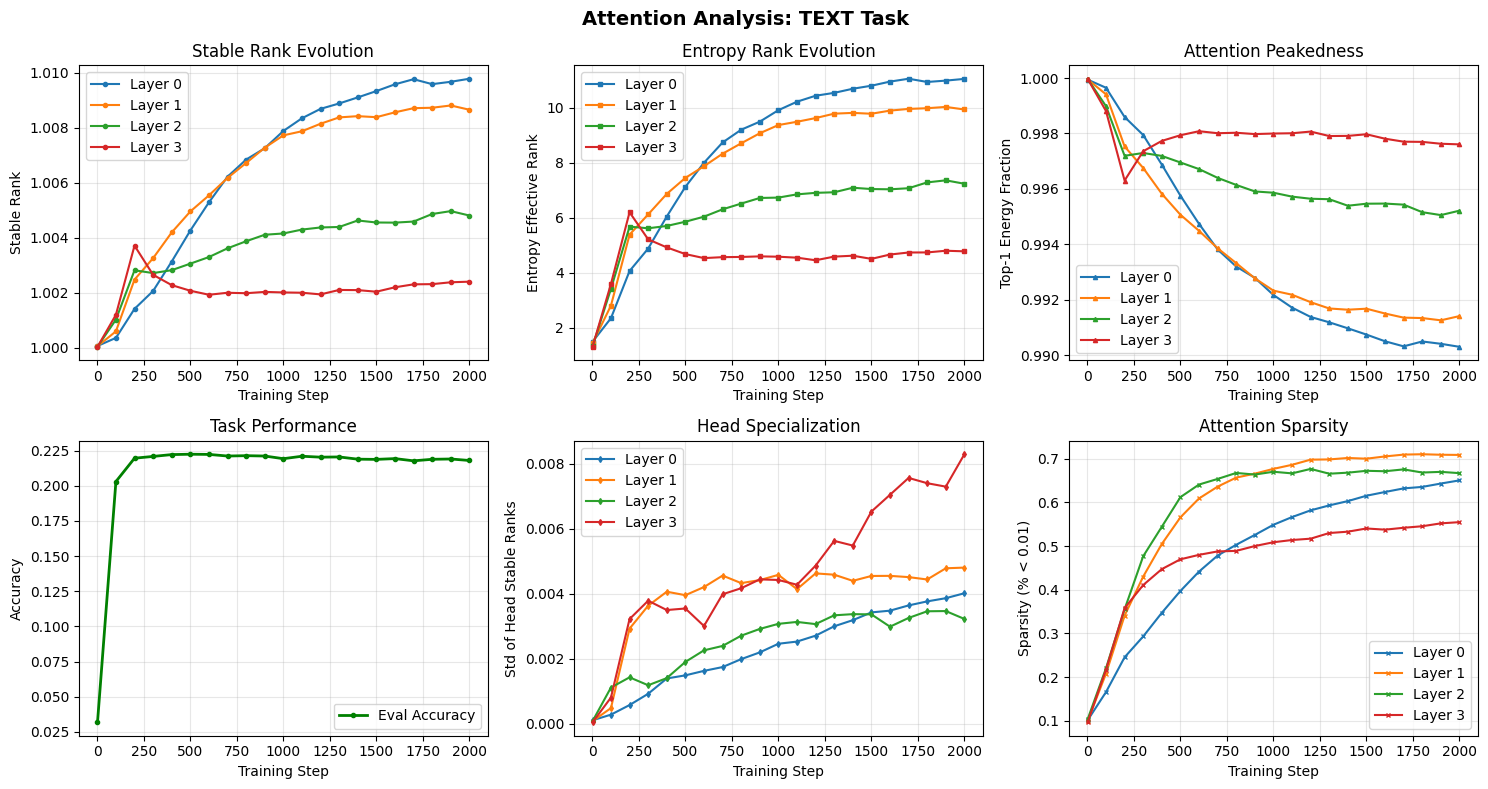


FINAL METRICS

Layer 0:
  head_stable_mean         : 1.0185
  head_stable_std          : 0.0040
  head_entropy_mean        : 13.3217
  head_top1_mean           : 0.9819
  mean_stable              : 1.0098
  mean_entropy_rank        : 11.0518
  mean_top1                : 0.9903
  mean_top3                : 0.9910
  sparsity                 : 0.6507

Layer 1:
  head_stable_mean         : 1.0168
  head_stable_std          : 0.0048
  head_entropy_mean        : 12.5016
  head_top1_mean           : 0.9835
  mean_stable              : 1.0087
  mean_entropy_rank        : 9.9393
  mean_top1                : 0.9914
  mean_top3                : 0.9920
  sparsity                 : 0.7090

Layer 2:
  head_stable_mean         : 1.0109
  head_stable_std          : 0.0032
  head_entropy_mean        : 9.7802
  head_top1_mean           : 0.9892
  mean_stable              : 1.0048
  mean_entropy_rank        : 7.2407
  mean_top1                : 0.9952
  mean_top3                : 0.9956
  sparsity      

In [15]:
# Enhanced Transformer attention-rank probe with harder tasks
# Larger model, longer training, more interesting dynamics

import os, time, math, random
from copy import deepcopy
from typing import Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ------------------------------
# Multiple Task Types
# ------------------------------
class CopyDataset(Dataset):
    """Simple copy - too easy"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y = x.clone()
        return x, y

class ReverseDataset(Dataset):
    """Reverse sequence - requires non-local attention"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y = torch.flip(x, dims=[0])
        return x, y

class SortDataset(Dataset):
    """Sort sequence - harder, requires global reasoning"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = torch.randint(low=1, high=vocab_size, size=(dataset_size, seq_len), dtype=torch.long)
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        x = self.data[idx].clone()
        y, _ = torch.sort(x)
        return x, y

class DuplicateDataset(Dataset):
    """Duplicate detection - attend to all positions"""
    def __init__(self, seq_len=32, vocab_size=16, dataset_size=4096):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dataset_size = dataset_size
        self.data = []
        for _ in range(dataset_size):
            seq = torch.randint(low=1, high=vocab_size, size=(seq_len,), dtype=torch.long)
            # Label: 1 if has duplicate, 0 otherwise
            unique_count = len(torch.unique(seq))
            label = 1 if unique_count < seq_len else 0
            self.data.append((seq, label))
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        return self.data[idx]

class TextPredictionDataset(Dataset):
    """Causal language modeling on character-level text"""
    def __init__(self, seq_len=64, dataset_size=4096, text_source='shakespeare'):
        self.seq_len = seq_len
        self.dataset_size = dataset_size

        # Generate synthetic "text-like" data with patterns
        if text_source == 'synthetic':
            # Create patterns: repeated subsequences, gradual changes
            vocab_size = 27  # a-z + space
            self.data = []
            for _ in range(dataset_size):
                seq = []
                # Add structured patterns
                for i in range(seq_len):
                    if i % 10 < 3:  # Repeating pattern every 10
                        val = (i % 10) + 1
                    elif i % 10 < 6:
                        val = ((i + dataset_size) % 15) + 1
                    else:
                        val = random.randint(1, vocab_size-1)
                    seq.append(val)
                self.data.append(torch.tensor(seq, dtype=torch.long))
            self.vocab_size = vocab_size
        else:
            # Simple text patterns
            vocab_size = 32
            self.vocab_size = vocab_size
            self.data = []
            for _ in range(dataset_size):
                # Create sequences with local dependencies
                seq = [random.randint(1, vocab_size-1)]
                for i in range(1, seq_len):
                    # 50% chance to depend on previous token, 50% random
                    if random.random() < 0.5:
                        seq.append((seq[-1] + random.randint(1, 5)) % vocab_size)
                    else:
                        seq.append(random.randint(1, vocab_size-1))
                self.data.append(torch.tensor(seq, dtype=torch.long))

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        seq = self.data[idx]
        # Input: seq[:-1], Target: seq[1:] (next token prediction)
        return seq[:-1].clone(), seq[1:].clone()

class ImageClassificationDataset(Dataset):
    """Flattened image patches for classification (MNIST-like)"""
    def __init__(self, img_size=8, num_classes=10, dataset_size=4096):
        self.img_size = img_size
        self.num_classes = num_classes
        self.dataset_size = dataset_size
        self.seq_len = img_size * img_size  # Flatten image to sequence
        self.vocab_size = 256  # Pixel values

        self.data = []
        for _ in range(dataset_size):
            # Generate synthetic images with class-specific patterns
            label = random.randint(0, num_classes - 1)

            # Create image with pattern based on class
            img = torch.zeros(img_size, img_size, dtype=torch.long)

            # Add class-specific patterns
            if label < 5:  # Vertical patterns
                col = label
                img[:, col] = 200
            else:  # Horizontal patterns
                row = label - 5
                img[row, :] = 200

            # Add noise
            noise = torch.randint(0, 50, (img_size, img_size), dtype=torch.long)
            img = torch.clamp(img + noise, 0, 255)

            # Flatten to sequence
            seq = img.flatten()
            self.data.append((seq, label))

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.data[idx]

# ------------------------------
# Enhanced Transformer
# ------------------------------
class MultiHeadAttentionWithCapture(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        assert self.head_dim * nhead == d_model

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        B, T, C = query.shape

        Q = self.q_proj(query).view(B, T, self.nhead, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(B, T, self.nhead, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(B, T, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if attn_mask is not None:
            scores = scores + attn_mask

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        output = self.out_proj(attn_output)

        return output, attn_weights

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttentionWithCapture(d_model, nhead, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        self.last_attn_weights = None

    def forward(self, x):
        attn_out, attn_weights = self.attn(x, x, x)
        self.last_attn_weights = attn_weights.detach().cpu().numpy()
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x

class EnhancedTransformer(nn.Module):
    def __init__(self, vocab_size=16, d_model=128, nhead=8, num_layers=4,
                 dim_feedforward=512, seq_len=32, max_pos=512, use_pos=True,
                 dropout=0.1, task_type='seq2seq', num_classes=10):
        super().__init__()
        self.seq_len = seq_len
        self.task_type = task_type
        self.embed = nn.Embedding(vocab_size, d_model)
        self.use_pos = use_pos
        if use_pos:
            self.pos_embed = nn.Parameter(torch.randn(1, max_pos, d_model) * 0.02)
        else:
            self.pos_embed = None

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

        # Different heads for different tasks
        if task_type == 'seq2seq' or task_type == 'causal_lm':
            self.head = nn.Linear(d_model, vocab_size)
        elif task_type == 'classification':
            self.head = nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model, num_classes)
            )

    def forward(self, x):
        B, T = x.shape
        emb = self.embed(x)
        if self.use_pos:
            pe = self.pos_embed[:, :T, :]
            emb = emb + pe

        out = emb
        for layer in self.layers:
            out = layer(out)

        out = self.norm(out)

        if self.task_type in ['seq2seq', 'causal_lm']:
            logits = self.head(out)
        elif self.task_type == 'classification':
            # Pool: mean across sequence
            pooled = out.mean(dim=1)
            logits = self.head(pooled)

        return logits

    def get_cached_attentions(self):
        return [layer.last_attn_weights for layer in self.layers]

# ------------------------------
# Metrics
# ------------------------------
def stable_rank_from_svals(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    fro_sq = np.sum(s**2)
    op_sq = (s[0]**2) if s.size>0 else 1e-12
    return float(max(1e-12, fro_sq / (op_sq + 1e-12)))

def entropy_effective_rank(svals):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    p = s / (s.sum() + 1e-12)
    p = p[p>0]
    ent = -np.sum(p * np.log(p + 1e-12))
    return float(np.exp(ent))

def topk_energy_fraction(svals, k=1):
    s = np.array(svals)
    if s.size == 0:
        return 0.0
    energy = np.sum(s**2)
    topk = np.sum(s[:k]**2)
    return float(topk / (energy + 1e-12))

def compute_layer_attention_metrics(attn_tensor):
    if attn_tensor is None:
        return {}
    B, nhead, T, _ = attn_tensor.shape
    mean_per_head = attn_tensor.mean(axis=0)
    mean_across_heads = mean_per_head.mean(axis=0)
    metrics = {}

    # Per-head metrics
    head_stable = []
    head_entropy_rank = []
    head_top1 = []

    for h in range(nhead):
        M = mean_per_head[h]
        try:
            svals = np.linalg.svd(M, compute_uv=False)
        except Exception:
            svals = np.linalg.svd(M + 1e-12 * np.eye(T), compute_uv=False)
        head_stable.append(stable_rank_from_svals(svals))
        head_entropy_rank.append(entropy_effective_rank(svals))
        head_top1.append(topk_energy_fraction(svals, k=1))

    metrics['head_stable_mean'] = float(np.mean(head_stable))
    metrics['head_stable_std'] = float(np.std(head_stable))
    metrics['head_entropy_mean'] = float(np.mean(head_entropy_rank))
    metrics['head_top1_mean'] = float(np.mean(head_top1))

    # Aggregated attention metrics
    M = mean_across_heads
    try:
        svals = np.linalg.svd(M, compute_uv=False)
    except Exception:
        svals = np.linalg.svd(M + 1e-12 * np.eye(T), compute_uv=False)
    metrics['mean_stable'] = stable_rank_from_svals(svals)
    metrics['mean_entropy_rank'] = entropy_effective_rank(svals)
    metrics['mean_top1'] = topk_energy_fraction(svals, k=1)
    metrics['mean_top3'] = topk_energy_fraction(svals, k=3)

    # Attention sparsity (what fraction of attention is near zero)
    attn_flat = attn_tensor.flatten()
    metrics['sparsity'] = float(np.mean(attn_flat < 0.01))

    return metrics

# ------------------------------
# Training
# ------------------------------
def run_experiment(task='reverse', seq_len=32, vocab_size=16, d_model=128, nhead=8,
                   num_layers=4, dim_feedforward=512, use_pos=True, batch_size=64,
                   steps=2000, probe_size=512, checkpoint_every=100, device=None, seed=0):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}, Task: {task}")
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    # Select dataset
    if task == 'copy':
        train_ds = CopyDataset(seq_len, vocab_size, 4096)
        probe_ds = CopyDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
        num_classes = 2
    elif task == 'reverse':
        train_ds = ReverseDataset(seq_len, vocab_size, 4096)
        probe_ds = ReverseDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
        num_classes = 2
    elif task == 'sort':
        train_ds = SortDataset(seq_len, vocab_size, 4096)
        probe_ds = SortDataset(seq_len, vocab_size, probe_size)
        task_type = 'seq2seq'
        num_classes = 2
    elif task == 'duplicate':
        train_ds = DuplicateDataset(seq_len, vocab_size, 4096)
        probe_ds = DuplicateDataset(seq_len, vocab_size, probe_size)
        task_type = 'classification'
        num_classes = 2
    elif task == 'text':
        train_ds = TextPredictionDataset(seq_len, 4096)
        probe_ds = TextPredictionDataset(seq_len, probe_size)
        vocab_size = train_ds.vocab_size
        task_type = 'causal_lm'
        num_classes = vocab_size
    elif task == 'image':
        img_size = 8  # 8x8 images
        train_ds = ImageClassificationDataset(img_size, 10, 4096)
        probe_ds = ImageClassificationDataset(img_size, 10, probe_size)
        seq_len = img_size * img_size
        vocab_size = 256
        task_type = 'classification'
        num_classes = 10

    model = EnhancedTransformer(vocab_size=vocab_size, d_model=d_model, nhead=nhead,
                                num_layers=num_layers, dim_feedforward=dim_feedforward,
                                seq_len=seq_len, use_pos=use_pos, task_type=task_type,
                                num_classes=num_classes)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    probe_loader = DataLoader(probe_ds, batch_size=64, shuffle=False)

    metrics_log = []
    step = 0
    start_time = time.time()

    # Progress bar
    pbar = tqdm(total=steps, desc=f"Training {task}", unit="step")

    while step < steps:
        for xb, yb in train_loader:
            model.train()
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)

            if task_type in ['seq2seq', 'causal_lm']:
                B, T, V = logits.shape
                loss = criterion(logits.view(B*T, V), yb.view(B*T))
            else:
                loss = criterion(logits, yb)

            optimizer.zero_grad(); loss.backward(); optimizer.step()
            step += 1
            pbar.update(1)
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            if step % checkpoint_every == 0 or step == 1:
                model.eval()
                with torch.no_grad():
                    # Collect attention
                    layer_attn_list = [[] for _ in range(num_layers)]
                    for pb_x, pb_y in probe_loader:
                        pb_x = pb_x.to(device)
                        _ = model(pb_x)
                        atts = model.get_cached_attentions()
                        for li, a in enumerate(atts):
                            if a is not None:
                                layer_attn_list[li].append(a)

                    layer_attn_concat = []
                    for li in range(num_layers):
                        if len(layer_attn_list[li]) > 0:
                            layer_attn_concat.append(np.concatenate(layer_attn_list[li], axis=0))
                        else:
                            layer_attn_concat.append(None)

                    per_layer_metrics = {}
                    for li, attn_tensor in enumerate(layer_attn_concat):
                        if attn_tensor is not None:
                            m = compute_layer_attention_metrics(attn_tensor)
                        else:
                            m = {'error': 'no attention captured'}
                        per_layer_metrics[f'layer{li}'] = m

                    # Evaluate
                    total_correct = 0
                    total_samples = 0
                    eval_loss = 0
                    for xb_eval, yb_eval in probe_loader:
                        xb_eval = xb_eval.to(device); yb_eval = yb_eval.to(device)
                        logits_eval = model(xb_eval)

                        if task_type in ['seq2seq', 'causal_lm']:
                            B_e, T_e, V = logits_eval.shape
                            eval_loss += criterion(logits_eval.view(B_e*T_e, V), yb_eval.view(B_e*T_e)).item()
                            pred = logits_eval.argmax(dim=-1)
                            total_correct += (pred == yb_eval).float().sum().item()
                            total_samples += B_e * T_e
                        else:
                            eval_loss += criterion(logits_eval, yb_eval).item()
                            pred = logits_eval.argmax(dim=-1)
                            total_correct += (pred == yb_eval).float().sum().item()
                            total_samples += yb_eval.shape[0]

                    acc = total_correct / total_samples
                    eval_loss = eval_loss / len(probe_loader)

                    pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.4f}'})

                    if step == checkpoint_every:
                        print(f"\nStep {step}: acc={acc:.4f}, eval_loss={eval_loss:.4f}")
                        for li, attn in enumerate(layer_attn_concat):
                            if attn is not None:
                                print(f"  Layer {li}: shape={attn.shape}, mean={attn.mean():.4f}, std={attn.std():.4f}")

                    metrics_log.append({
                        'step': step, 'time': time.time()-start_time,
                        'train_loss': float(loss.item()),
                        'eval_loss': float(eval_loss),
                        'eval_acc': float(acc),
                        'per_layer': per_layer_metrics
                    })
                model.train()
            if step >= steps:
                break

    pbar.close()
    print(f"Done training in {time.time()-start_time:.1f}s")
    return model, metrics_log

# ------------------------------
# Visualization
# ------------------------------
def plot_results(metrics_log, num_layers, task_name):
    steps = [m['step'] for m in metrics_log]
    eval_acc = [m['eval_acc'] for m in metrics_log]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Attention Analysis: {task_name.upper()} Task', fontsize=14, fontweight='bold')

    # Stable rank
    ax = axes[0, 0]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_stable', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='o', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Stable Rank')
    ax.set_title('Stable Rank Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Entropy effective rank
    ax = axes[0, 1]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_entropy_rank', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='s', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Entropy Effective Rank')
    ax.set_title('Entropy Rank Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Top-1 energy
    ax = axes[0, 2]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('mean_top1', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='^', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Top-1 Energy Fraction')
    ax.set_title('Attention Peakedness')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Accuracy
    ax = axes[1, 0]
    ax.plot(steps, eval_acc, label='Eval Accuracy', marker='o', markersize=3, color='green', linewidth=2)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Accuracy')
    ax.set_title('Task Performance')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Per-head stable rank variation
    ax = axes[1, 1]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('head_stable_std', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='d', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Std of Head Stable Ranks')
    ax.set_title('Head Specialization')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Sparsity
    ax = axes[1, 2]
    for li in range(num_layers):
        vals = [m['per_layer'].get(f'layer{li}', {}).get('sparsity', 0) for m in metrics_log]
        ax.plot(steps, vals, label=f'Layer {li}', marker='x', markersize=3)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Sparsity (% < 0.01)')
    ax.set_title('Attention Sparsity')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ------------------------------
# Demo
# ------------------------------
def demo_and_plot():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Choose task: 'copy', 'reverse', 'sort', 'duplicate', 'text', 'image'
    task = 'text'  # Try 'text' or 'image' for realistic tasks!

    print("\n" + "="*70)
    print("ATTENTION RANK EVOLUTION EXPERIMENT")
    print("="*70)
    print(f"\nTask: {task.upper()}")
    print("\nHypothesis on rank evolution:")
    if task == 'text':
        print("- Text prediction: Rank may DECREASE as model learns")
        print("  local patterns (attend to recent tokens)")
        print("- Early layers: Higher rank (broad context)")
        print("- Later layers: Lower rank (focused on prediction)")
    elif task == 'image':
        print("- Image classification: Rank evolution depends on patterns")
        print("- May see rank DECREASE as model learns discriminative")
        print("  features (attend to specific patches)")
    elif task in ['reverse', 'sort']:
        print("- Complex reasoning: Rank may stay HIGH or even INCREASE")
        print("  as model learns global attention patterns")
    print("="*70 + "\n")

    model, metrics_log = run_experiment(
        task=task,
        seq_len=64 if task == 'text' else 32,
        vocab_size=16,
        d_model=128,
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        use_pos=True,
        batch_size=64,
        steps=2000,
        probe_size=512,
        checkpoint_every=100,
        device=device,
        seed=42
    )

    plot_results(metrics_log, num_layers=4, task_name=task)

    # Print final metrics
    print("\n" + "="*60)
    print("FINAL METRICS")
    print("="*60)
    final = metrics_log[-1]['per_layer']
    for li in range(4):
        print(f"\nLayer {li}:")
        layer_metrics = final.get(f'layer{li}', {})
        for k, v in layer_metrics.items():
            if isinstance(v, float):
                print(f"  {k:25s}: {v:.4f}")

    # Analyze rank trends
    print("\n" + "="*60)
    print("RANK EVOLUTION ANALYSIS")
    print("="*60)
    for li in range(4):
        stable_ranks = [m['per_layer'].get(f'layer{li}', {}).get('mean_stable', 0)
                       for m in metrics_log]
        if len(stable_ranks) > 1:
            early = np.mean(stable_ranks[:3])
            late = np.mean(stable_ranks[-3:])
            change = late - early
            direction = "INCREASED" if change > 0 else "DECREASED"
            print(f"Layer {li}: Stable rank {direction} by {abs(change):.4f}")
            print(f"  Early: {early:.4f}, Late: {late:.4f}")

    # Save
    import json
    with open(f'metrics_{task}.json', 'w') as f:
        json.dump(metrics_log, f, indent=2)
    print(f"\nSaved metrics_{task}.json")

if __name__ == "__main__":
    demo_and_plot()